## Step 0: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from prophet import Prophet
#from fbprophet import Prophet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold


Importing plotly failed. Interactive plots will not work.


## STEP 1. LOOK AT THE BIG PICTURE (DONE)

# 1. Dataset's Source:
We got this dataset from: https://www.visualcrossing.com/. 

Visual Crossing is considered a reputable source for weather data for several reasons:
- Comprehensive Coverage: It offers extensive historical and forecast data for various locations, ensuring users have access to accurate information.

- User-Friendly API: The well-documented API allows easy integration into applications, making it popular among developers.

- Accuracy: Data is sourced from reputable meteorological organizations, ensuring high reliability and quality.

- Positive Feedback: Users report satisfaction with the service, highlighting its usability and responsive support.

- Industry Use: Trusted by sectors like agriculture and finance, its data is crucial for decision-making.

- These factors contribute to Visual Crossing's strong reputation in the weather data industry.

# 2. Data.csv Feature Explanation
This dataset contains weather data of Hanoi (from 01/01/2020 to 20/08/2024). Each feature is described below, along with the intended analysis goals.

# 3. Features Explanation:
- **name**: The name of the location where the data was recorded (e.g., city name).
- **datetime**: The date and time when the data was recorded.
- **tempmax**: The maximum temperature recorded on that day.
- **tempmin**: The minimum temperature recorded on that day.
- **temp**: The average temperature recorded on that day.
- **feelslikemax**: The maximum "feels like" temperature, which is a measure of how hot or cold it feels.
- **feelslikemin**: The minimum "feels like" temperature.
- **feelslike**: The average "feels like" temperature.
- **dew**: The dew point temperature, which indicates the temperature at which air becomes saturated with moisture.
- **humidity**: The percentage of humidity in the air.
- **precip**: The amount of precipitation (rainfall) recorded.
- **precipprob**: The probability of precipitation occurring.
- **precipcover**: The percentage of the area that experienced precipitation.
- **preciptype**: The type of precipitation (e.g., rain, snow).
- **snow**: The amount of snowfall recorded.
- **snowdepth**: The depth of snow accumulation.
- **windgust**: The maximum speed of wind gusts recorded.
- **windspeed**: The average wind speed recorded.
- **winddir**: The direction of the wind, measured in degrees.
- **sealevelpressure**: The atmospheric pressure at sea level.
- **cloudcover**: The percentage of the sky covered by clouds.
- **visibility**: The distance at which objects can be clearly seen.
- **solarradiation**: The amount of solar radiation received, measured in W/m².
- **solarenergy**: The amount of solar energy received, measured in MJ/m².
- **uvindex**: The level of ultraviolet (UV) radiation.
- **severerisk**: The risk level for severe weather events.
- **sunrise**: The time of sunrise.
- **sunset**: The time of sunset.
- **moonphase**: The phase of the moon, indicating how full or new the moon is.
- **conditions**: A brief description of the weather conditions (e.g., clear, rainy).
- **description**: A detailed description of the weather conditions.
- **icon**: A weather icon representing the condition.
- **stations**: The identifiers of the weather stations that recorded the data.

# 4. Output Label: 
The output label is **temp**. (from August 21, 2024, to December 31, 2024.)

# 5. Analysis goals:
Predicting temperature specifically plays a crucial role in human life by helping people make informed decisions about daily activities, energy consumption, and health management. For instance, accurate temperature forecasts allow individuals to dress appropriately for the weather, avoiding discomfort or health risks such as heatstroke in high temperatures or hypothermia in cold conditions. Businesses, especially those in industries like agriculture and construction, rely on temperature predictions to plan operations efficiently and protect their resources. Additionally, power companies use temperature forecasts to manage energy demand, ensuring that heating or cooling systems are adequately supplied. Thus, temperature predictions directly influence safety, productivity, and resource management in everyday life.

# 6. Instruction on getting the csv file and set-up the environment:
/* insert caption here*/

## 7. About our process and steps:
Here’s a concise explanation of the steps in the script and why it's important to follow this process:

1. Data Collection: Gathering accurate and relevant data is crucial for building a reliable model. Quality data leads to better insights and predictions.

2. Data Preprocessing: Cleaning and preparing the data (handling missing values, encoding categorical variables) ensures that the model receives high-quality input. This step reduces noise and improves model accuracy.

3. Feature Selection/Engineering: Selecting or creating relevant features helps the model focus on the most important information, enhancing its predictive power and efficiency.

4. Data Normalization (using StandardScaler): Standardizing features ensures they are on the same scale, improving model performance and reducing bias towards certain features.

5. Model Training: Training the model on the prepared data allows it to learn patterns and relationships, which is essential for making predictions.

6. Model Evaluation: Evaluating the model's performance using metrics helps identify its effectiveness and areas for improvement, ensuring it meets the desired accuracy.

7. Hyperparameter Tuning: Fine-tuning model parameters optimizes performance, allowing the model to generalize better to unseen data.

8. Deployment: Deploying the model makes it accessible for real-world applications, enabling users to benefit from its predictions.

Following this structured process ensures a systematic approach to building effective machine learning models, leading to reliable and actionable insights.

## STEP 2. GET THE DATA (DONE). LOAD DATA

In [2]:
raw_data = pd.read_csv(r'dataset/Data.csv')
# raw_data.head(10) preview the first 10 column
#raw_data.tail() preview the last 10 column 

## STEP 3. DISCOVER THE DATA TO GAIN INSIGHTS

/* Here is the function for plotting data for each year */

In [3]:
# Function to plot the data for each year
def plot_year_data(year):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx()  # Create a secondary axis for the bar chart

    # Plot temperature and feels like as line charts
    ax.plot(monthly_avg.index, monthly_avg['temp'][year], label=f'Temp {year}', color='red')
    ax.plot(monthly_avg.index, monthly_avg['feelslike'][year], label=f'Feels Like {year}', color='red', linestyle='dashed')

    # Plot precipitation as a bar chart
    ax2.bar(monthly_avg.index, monthly_avg['precip'][year], color='blue', alpha=0.3, label=f'Precip {year}')

    # Set the axis labels and title
    ax.set_title(f'Temperature, Feels Like, and Precipitation in {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature (°C)', color='red')
    ax2.set_ylabel('Precipitation (mm)', color='blue')

    # Set custom month labels on the x-axis
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months)

    # Add legends outside of the plot area, further right
    ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))

    # Grid for better readability
    ax.grid(True)

    # Adjust layout and leave space for the legends
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1694 entries, 0 to 1693
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1694 non-null   object 
 1   datetime          1694 non-null   object 
 2   tempmax           1694 non-null   float64
 3   tempmin           1694 non-null   float64
 4   temp              1694 non-null   float64
 5   feelslikemax      1694 non-null   float64
 6   feelslikemin      1694 non-null   float64
 7   feelslike         1694 non-null   float64
 8   dew               1694 non-null   float64
 9   humidity          1694 non-null   float64
 10  precip            1694 non-null   float64
 11  precipprob        1694 non-null   int64  
 12  precipcover       1694 non-null   float64
 13  preciptype        1238 non-null   object 
 14  snow              1694 non-null   int64  
 15  snowdepth         1694 non-null   int64  
 16  wi

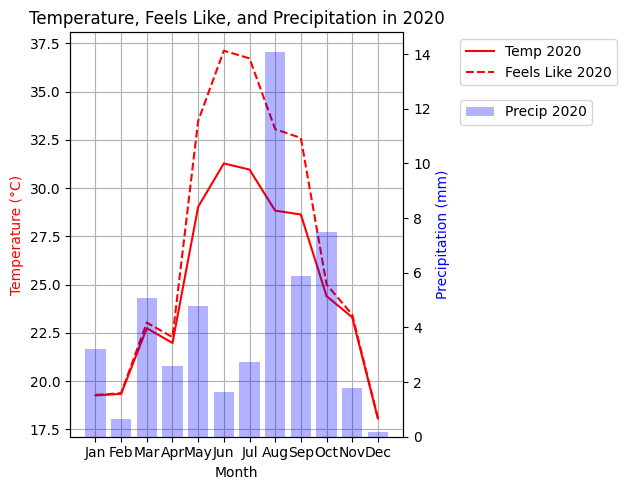

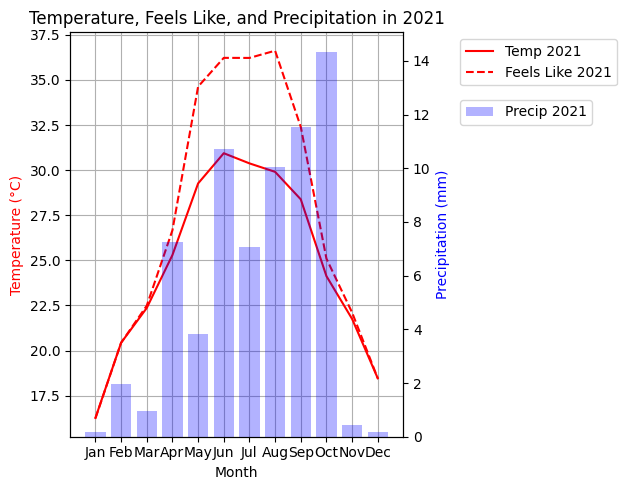

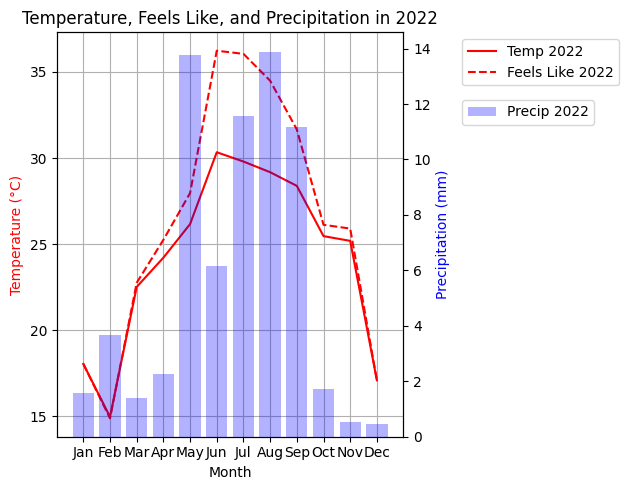

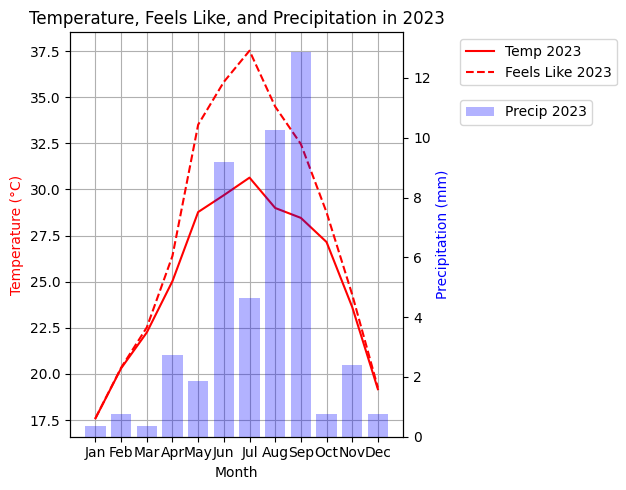

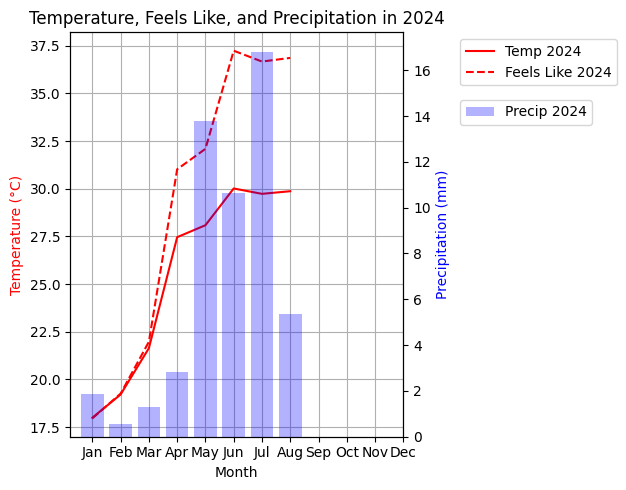

In [4]:
# 3.1 Quick view of the data
print('\n____________ Dataset info ____________')
print(raw_data.info())              
print('\n____________ Some first data examples ____________')
print(raw_data.head(5)) 
print('\n____________ Counts on a feature ____________')
# print(raw_data['LEGAL DOCUMENTS'].value_counts()) 
print('\n____________ Statistics of numeric features ____________')
print(raw_data.describe())    
print('\n____________ Get specific rows and cols ____________')     
print(raw_data.iloc[[0,1,45], [2, 5]] ) # Refer using column ID


# Convert 'datetime' column to pandas datetime
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])

# Extract the year from the 'datetime' column into a new 'year' column
raw_data['year'] = raw_data['datetime'].dt.year

# Filter data for the years 2020 to 2024
years = [2020, 2021, 2022, 2023, 2024]
filtered_data = raw_data[raw_data['year'].isin(years)]

# Group the data by year and month, and calculate the average temp, feels like, and precip for each month
monthly_avg = filtered_data.groupby([filtered_data['datetime'].dt.month, filtered_data['datetime'].dt.year])[['temp', 'feelslike', 'precip']].mean().unstack(1)

# Define month names for the x-axis
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the data for each year separately (2020 to 2023)
for year in years[:-1]:  # Exclude 2024
    plot_year_data(year)

# Plot the data for 2024 in a separate figure
plot_year_data(2024)


## Step 4: Prepare the data


4.1 Find features(based on MI) that related to the target label:

**Why Use Mutual Information Over Correlation?**

Mutual Information (MI) offers several advantages over traditional correlation measures in data analysis. Unlike correlation, which primarily captures linear relationships, MI can detect non-linear associations between variables, making it particularly valuable in complex systems such as weather prediction. MI doesn't make assumptions about data distribution, contrasting with some correlation measures that presume normal distribution. It's versatile enough to handle both continuous and categorical variables, whereas correlation typically works best with continuous data. MI's sensitivity to complex dependencies allows it to uncover intricate relationships that correlation might overlook. Additionally, MI is scale-invariant, meaning it's not affected by scale transformations of the variables. These characteristics make MI a powerful tool for feature selection and understanding variable relationships, especially in datasets where traditional correlation analysis might fall short.

**Interpreting the MI scores of our script after compilation:**

The MI score quantifies the amount of information obtained about the target variable (in this case, temperature) by observing the feature variable. Higher scores indicate stronger relationships. Here's what we can interpret from your results:

- 'feelslike' has the highest MI score (3.176038), suggesting it's the most informative feature for predicting temperature. This makes sense intuitively, as "feels like" temperature is closely related to actual temperature.
- 'feelslikemax' and 'tempmax' have very similar scores (1.596926 and 1.595622), indicating they provide similar amounts of information about the target.
- 'tempmin' and 'feelslikemin' also have high scores, further emphasizing the importance of temperature-related features.
- 'dew' point has a relatively high score (1.020049), which is reasonable as dew point is related to temperature and humidity.
- 'sealevelpressure' has a moderate score (0.692677), suggesting some relationship with temperature.
- Features like 'solarradiation', 'humidity', 'solarenergy', and 'cloudcover' have lower but non-negligible scores, indicating they provide some information about temperature.
- 'snow' and 'snowdepth' have scores of 0, suggesting they provide no information about temperature in this dataset. This could be due to the absence of snow in the data or a very weak relationship.


In [5]:
# Load the dataset
file_path = 'dataset/Data.csv'  # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Select only the numeric columns from the dataset
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data_numeric = data[numeric_cols]

# Drop rows with missing values (NaN) in the numeric dataset
data_numeric_cleaned = data_numeric.dropna()

# Prepare the feature set (all numeric features except `temp`)
X = data_numeric_cleaned.drop(columns=['temp', 'severerisk', 'precipprob'])  # Drop 'temp' (target variable)
y = data_numeric_cleaned['temp']  # Target variable

# Step 1: Calculate Mutual Information
mi = mutual_info_regression(X, y)

# Create a DataFrame for mutual information
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
}).sort_values(by='Mutual Information', ascending=False)

# Print mutual information
print("Mutual Information between Features and Target:")
print(mi_df)

# Step 2: Select top features based on MI (lấy tất cả những chỉ số MI trên 0.25)
top_features = mi_df['Feature'].head(8).values ## Có 10 chỉ số MI trên 0.25
print(f"Top features correlate to feature 'temp' based on MI: {top_features}")

Mutual Information between Features and Target:
             Feature  Mutual Information
4          feelslike            3.187319
2       feelslikemax            1.594298
0            tempmax            1.585793
1            tempmin            1.420930
3       feelslikemin            1.395058
5                dew            1.026666
14  sealevelpressure            0.688739
6           humidity            0.309805
17    solarradiation            0.303636
18       solarenergy            0.302755
15        cloudcover            0.296586
16        visibility            0.280120
19           uvindex            0.233808
13           winddir            0.195511
7             precip            0.109625
11          windgust            0.069340
8        precipcover            0.043081
20         moonphase            0.023731
12         windspeed            0.016854
9               snow            0.000000
10         snowdepth            0.000000
Top features correlate to feature 'temp' based on 

4.1.1. Drop columns

In [6]:
# List of features to keep
features_to_keep = ['feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin', 'dew',
                     'sealevelpressure', 'humidity', 'temp']

# Drop columns that are not in the list of features to keep
raw_data = raw_data[features_to_keep]
print("Dropped columns successfully. Feature to keeps: ", features_to_keep)
print(raw_data.head())

Dropped columns successfully. Feature to keeps:  ['feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity', 'temp']
   feelslike  tempmax  feelslikemax  tempmin  feelslikemin   dew  \
0       21.2     23.0          23.0     19.9          19.9  17.4   
1       21.7     24.0          24.0     19.8          19.8  18.4   
2       22.6     25.5          25.5     20.4          20.4  18.4   
3       21.4     24.5          24.5     20.0          20.0  19.1   
4       21.3     24.5          24.5     19.0          19.0  19.1   

   sealevelpressure  humidity  temp  
0            1023.8      79.3  21.2  
1            1022.2      82.3  21.7  
2            1020.2      77.8  22.6  
3            1018.5      87.2  21.4  
4            1017.4      87.9  21.3  


4.2. Shift label for future prediction

We need to predict the temperature based on historical data. Hence we need to shift the label up so that the predicted temp is based on past data.

- Purpose: To predict the temperature for a future day, historical data from previous days must be used. Shifting the labels creates a relationship between past data and future predictions.
- How It Works:
k = -2 indicates that the "temp" label will be shifted up by 2 rows. This means that the current temperature value will be assigned to the label for two days prior.
As a result, if the original data row has a temperature of 25°C on day 1, after shifting, the data row for day 1 will have a temperature label of 25°C for day 3.

In [7]:
k = -1
raw_data['temp'] = raw_data['temp'].shift(k)

# Drop the rows with NaN values that were created by the shift
raw_data = raw_data.dropna()

# Optional: print the first few rows to verify
print(raw_data.head())


   feelslike  tempmax  feelslikemax  tempmin  feelslikemin   dew  \
0       21.2     23.0          23.0     19.9          19.9  17.4   
1       21.7     24.0          24.0     19.8          19.8  18.4   
2       22.6     25.5          25.5     20.4          20.4  18.4   
3       21.4     24.5          24.5     20.0          20.0  19.1   
4       21.3     24.5          24.5     19.0          19.0  19.1   

   sealevelpressure  humidity  temp  
0            1023.8      79.3  21.7  
1            1022.2      82.3  22.6  
2            1020.2      77.8  21.4  
3            1018.5      87.2  21.3  
4            1017.4      87.9  22.6  


4.2 Split-training the dataset:

In our regression problem, Stratified Sampling is not necessary because the features and target values are continuous rather than categorical. Stratified Sampling is typically used in classification problems to maintain the distribution of target classes across datasets. In regression, where the goal is to predict continuous values, maintaining class proportions is irrelevant and does not impact the model's performance. Therefore, I will focus on data normalization and model optimization to enhance prediction accuracy.

In [8]:
# Split the data into training and test sets
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=42)  # Set random_state to get the same training set each time, 
                                                                                     # otherwise, when repeating training many times, your model might see all the data
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))


____________ Split training and test set ____________
1354 training + 339 test examples
      feelslike  tempmax  feelslikemax  tempmin  feelslikemin   dew  \
1385       27.7     32.1          32.7     22.0          22.0  19.8   
752        18.4     21.4          21.4     16.0          16.0  17.3   
408        19.3     22.0          22.0     17.0          17.0  14.5   
1653       38.3     36.1          48.1     27.0          30.1  26.1   

      sealevelpressure  humidity  temp  
1385            1013.8      66.6  27.6  
752             1011.1      93.5  20.6  
408             1017.1      74.4  19.5  
1653            1003.1      78.3  31.5  


4.3 Separate labels from data, since we do not process label values (already processed)

In [9]:
# Separate labels from data
X_train = train_set.drop(columns=['temp'])
y_train = train_set['temp']
X_test = test_set.drop(columns=['temp'])
y_test = test_set['temp']

4.4. Define pipelines for processing data.

4.4.1. Define ColumnSelector: a transformer for choosing columns

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin): #i 1.78318331162308n):
    # Hàm khởi tạo nhận vào danh sách các tên cột cần chọn
    def __init__(self, feature_names):
        self.feature_names = feature_names  # Lưu trữ danh sách tên cột

    # Phương thức fit không cần thực hiện gì, chỉ trả về chính đối tượng này
    # để tương thích với quy trình của scikit-learn
    def fit(self, dataframe, labels=None):
        return self

    # Phương thức transform chọn các cột từ DataFrame dựa trên danh sách tên cột
    # và trả về các giá trị dưới dạng mảng NumPy
    def transform(self, dataframe):
        return dataframe[self.feature_names].values  # Chọn và trả về các cột dưới dạng mảng NumPy


In [11]:
#numerical features
num_feat_names = ['feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity']

4.4.2. Pipeline for categorical features:

4.4.3. KHÔNG CẦN LÀM BƯỚC NÀY

4.4.4. Pipeline for numerical features

In [12]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', ColumnSelector(num_feat_names)),  # Chọn các cột numeric
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),  # Điền giá trị thiếu bằng median
    ('std_scaler', StandardScaler(with_mean=True, with_std=True))  # Chuẩn hóa về zero mean và unit variance
])

4.4.5 Run the pipeline to process training data

**Using StandardScaler in the script has several key reasons:**

- Data Normalization: It standardizes features to have a mean of 0 and a standard deviation of 1, ensuring all features are on the same scale.

- Improved Model Performance: Many machine learning algorithms, especially distance-based ones like KNN, perform better with normalized data, leading to faster convergence and higher accuracy.

- Reduced Bias: It minimizes bias towards features with larger values by bringing all features to a similar range.

- Increased Stability: Standardization enhances model stability, particularly in the presence of outliers.

In **summary**, StandardScaler improves model performance, accuracy, and stability.

In [13]:
processed_train_set_val = num_pipeline.fit_transform(train_set)

# Fit the pipeline on training data and transform both training and test data
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)
X_train = pd.DataFrame(X_train, columns=num_feat_names)
X_test = pd.DataFrame(X_test, columns=num_feat_names)


print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :])  # In ra một vài hàng đầu tiên sau khi xử lý
print(processed_train_set_val.shape)  # In ra kích thước của dữ liệu đã xử lý
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')   # Lưu pipeline vào file


____________ Processed feature values ____________
[[ 0.06038664  0.62390555  0.0387395   0.03214117 -0.1070797  -0.068793
   0.35842296 -1.00189676]
 [-1.12959865 -1.17479679 -1.13846414 -1.17896664 -1.07429727 -0.49210566
  -0.02323924  1.46731129]
 [-1.01443878 -1.07393498 -1.07595775 -0.97711534 -0.91309434 -0.96621584
   0.82489897 -0.28591822]]
(1354, 8)


['models/num_pipeline.pkl']

## Step 5: Train and evaluate model.

5.1. Try Light GBM model

5.1.1. Training: Learn a lgbm model using training data

In [14]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

In [15]:
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

5.1. Try Light GBM model

In [16]:
model = lgb.LGBMRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ LGBMRegressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 1354, number of used features: 8
[LightGBM] [Info] Start training from score 24.747932

____________ LGBMRegressor ____________

R2 score (on training data, best=1): 0.9669448674481183
Root Mean Square Error:  0.9

Predictions:  [29.2 28.3 28.1 27.8 30.5 20.5 22.2 29.  18.8]
Labels:       [28.4, 28.7, 25.7, 27.2, 26.9, 21.8, 20.5, 29.0, 18.5]
Model successfully saved as LGBMRegressor_model.pkl


5.2. Try XGB model

In [17]:
model = XGBRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ XGBoost_Regressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________ XGBoost_Regressor ____________

R2 score (on training data, best=1): 0.9971881066365246
Root Mean Square Error:  0.2754226075470016

Predictions:  [29.4 28.3 28.2 26.8 30.  19.7 21.8 28.4 18.4]
Labels:       [28.4, 28.7, 25.7, 27.2, 26.9, 21.8, 20.5, 29.0, 18.5]
Model successfully saved as XGBRegressor_model.pkl


5.3 Try Prophet Model


In [18]:
import pandas as pd
from prophet import Prophet
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score, mean_squared_error
import joblib

class DateAdder(BaseEstimator, TransformerMixin):
    def __init__(self, start_date='2020-01-01'):
        self.start_date = pd.to_datetime(start_date)
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Create a 'ds' column with sequential dates starting from 'start_date'
        X['ds'] = pd.date_range(start=self.start_date, periods=len(X), freq='D')
        return X

class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, yearly_seasonality=True):
        self.yearly_seasonality = yearly_seasonality
        self.model = None

    def fit(self, X, y=None):
        df = X.copy()
        df['y'] = y  # Prophet requires the target column to be named 'y'
        self.model = Prophet(yearly_seasonality=self.yearly_seasonality)
        
        # Add additional regressors
        for col in X.columns:
            if col != 'ds':  # Assuming 'ds' is the date column created in the pipeline
                self.model.add_regressor(col)
                
        self.model.fit(df[['ds', 'y'] + [col for col in X.columns if col != 'ds']])
        return self

    def predict(self, X, y=None):
        forecast = self.model.predict(X[['ds'] + [col for col in X.columns if col != 'ds']])
        return forecast['yhat']

# Function to calculate R² score and RMSE
def r2score_and_rmse(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    return r2, rmse

# Function to store model
def store_model(model, model_name="Prophet_model.pkl"):
    joblib.dump(model, model_name)
    print(f"Model successfully saved as {model_name}")

# Initialize and train the model using the pipeline
pipeline = Pipeline([
    ('date_adder', DateAdder(start_date='2020-01-01')),  # Add a 'ds' date column
    ('prophet', ProphetWrapper(yearly_seasonality=True))  # Prophet model wrapper
])

pipeline.fit(X_train, y_train)

print('\n____________ Prophet_Model ____________')

r2score, rmse = r2score_and_rmse(pipeline, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Predict labels for some test instances
print(f"Predictions: {pipeline.predict(X_test[:9]).round(decimals=1)}")
print("\nLabels: ", list(y_test[:9]))

# Store the trained model
store_model(pipeline, model_name="Prophet_model.pkl")


21:04:28 - cmdstanpy - INFO - Chain [1] start processing
21:04:29 - cmdstanpy - INFO - Chain [1] done processing



____________ Prophet_Model ____________


/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



R2 score (on training data, best=1): -0.8897344289997169
Root Mean Square Error:  7.140038442025039
Predictions: 0    19.2
1    19.0
2    18.8
3    19.2
4    18.2
5    18.9
6    18.6
7    18.7
8    18.7
Name: yhat, dtype: float64

Labels:  [28.4, 28.7, 25.7, 27.2, 26.9, 21.8, 20.5, 29.0, 18.5]
Model successfully saved as Prophet_model.pkl


5.4 Try Decision Tree (in-lecture)

In [19]:
model = DecisionTreeRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________DecisionTreeRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________DecisionTreeRegressor____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [28.  29.7 28.9 26.  30.3 19.8 21.3 30.3 19.8]
Labels:       [28.4, 28.7, 25.7, 27.2, 26.9, 21.8, 20.5, 29.0, 18.5]
Model successfully saved as Prophet_model.pkl


/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.5 Try Polynomial Regression (in-lecture)

In [20]:
# Sử dụng PolynomialFeatures kết hợp với một mô hình hồi quy
degree = 2  # Độ của đa thức bạn muốn tạo
model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('lin_reg', LinearRegression())
])

model.fit(X_train, y_train)

print('\n____________PolynomialRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________PolynomialRegressor____________

R2 score (on training data, best=1): 0.9033095279361196
Root Mean Square Error:  1.6150724260563627

Predictions:  [29.3 29.6 27.4 27.7 30.2 20.1 21.4 28.8 20. ]
Labels:       [28.4, 28.7, 25.7, 27.2, 26.9, 21.8, 20.5, 29.0, 18.5]
Model successfully saved as Prophet_model.pkl


/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.6. Try Linear Regressor (in-lecture)

In [21]:
model = LinearRegression() #fix here
model.fit(X_train, y_train)

print('\n____________LinearRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________LinearRegressor____________

R2 score (on training data, best=1): 0.8946176564679356
Root Mean Square Error:  1.6861029507821443

Predictions:  [30.4 29.6 26.7 27.8 29.9 20.1 21.4 28.8 18.9]
Labels:       [28.4, 28.7, 25.7, 27.2, 26.9, 21.8, 20.5, 29.0, 18.5]
Model successfully saved as Prophet_model.pkl


/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.7. Random Forest (in-lecture)

In [22]:
model = RandomForestRegressor(n_estimators = 5)
model.fit(X_train, y_train)

print('\n____________RandomForestRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)



# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

store_model(model)


____________RandomForestRegressor____________

R2 score (on training data, best=1): 0.9725542942346052
Root Mean Square Error:  0.8604732303836039

Predictions:  [28.8 27.9 29.  27.9 30.7 19.2 20.  29.1 19.4]
Labels:       [28.4, 28.7, 25.7, 27.2, 26.9, 21.8, 20.5, 29.0, 18.5]
Model successfully saved as Prophet_model.pkl


/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.8. K-Nearest-Neighbor

In [23]:
model = KNeighborsRegressor(n_neighbors=5)  # fix here
model.fit(X_train, y_train)

print('\n____________KNeighborsRegressor____________')

# Tính toán r2 score và rmse
r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Dự đoán nhãn cho một số mẫu thử nghiệm
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

# Lưu mô hình đã huấn luyện
store_model(model)


____________KNeighborsRegressor____________

R2 score (on training data, best=1): 0.9228417210694209
Root Mean Square Error:  1.442751146765053

Predictions:  [28.2 28.1 27.8 27.9 30.2 20.6 21.3 29.3 18.4]
Labels:       [28.4, 28.7, 25.7, 27.2, 26.9, 21.8, 20.5, 29.0, 18.5]
Model successfully saved as Prophet_model.pkl


/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.9. Try using SVR

In [24]:
model = SVR(kernel='rbf')  # fix here, với kernel 'rbf' mặc định
model.fit(X_train, y_train)

print('\n____________Support Vector Regressor (SVR)____________')

# Tính toán r2 score và rmse
r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Dự đoán nhãn cho một số mẫu thử nghiệm
print("\nPredictions: ", model.predict(X_test[:9]).round(decimals=1))
print("Labels:      ", list(y_test[:9]))

# Lưu mô hình đã huấn luyện
store_model(model)



____________Support Vector Regressor (SVR)____________

R2 score (on training data, best=1): 0.8928453540381556
Root Mean Square Error:  1.7002221319208117

Predictions:  [29.8 29.4 26.9 28.1 30.5 20.4 21.6 28.8 19. ]
Labels:       [28.4, 28.7, 25.7, 27.2, 26.9, 21.8, 20.5, 29.0, 18.5]
Model successfully saved as Prophet_model.pkl


/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.10. Evaluate with K-fold cross validation

In [25]:
# Train và dự đoán theo cách thủ công với Prophet
def train_and_evaluate(model, train_df, test_df, y_test):
    model.fit(train_df)
    
    # Tạo dự đoán trên dữ liệu kiểm tra
    future = test_df.copy()
    forecast = model.predict(future)
    
    y_pred = forecast['yhat']
    
    # Tính RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

In this K-Cross Validation, we will evaluate the models based on their RMSE scores statistics and their residual distribution

### Why We Chose to Evaluate the Model Using Average RMSE

In our temperature prediction project, we have chosen to evaluate model performance using the **Average RMSE (Root Mean Squared Error)** after applying k-fold cross-validation. This decision is based on several key reasons:

1. **Measuring Absolute Errors**: RMSE allows us to measure the average absolute error between the model’s predictions and the actual temperature values. This is crucial for our project, as it requires a model that can provide the most accurate predictions possible. A low RMSE ensures that the prediction errors are minimal, reducing the risk when applying the model in real-world scenarios.

2. **Weighting Larger Errors**: RMSE emphasizes larger errors (outliers) by squaring the differences, which helps us identify and optimize the model to minimize the most inaccurate predictions. This is particularly important in temperature prediction, where large errors can lead to inaccurate decisions in control systems or forecasting.

3. **Intuitive Interpretation**: RMSE is calculated in the same units as the target variable (temperature), making it easier to interpret the magnitude of the model's errors. For instance, if a model’s RMSE is 1.5°C, we can easily visualize that the model’s predictions deviate from the actual values by an average of 1.5°C, making it easier to communicate this information to stakeholders.

4. **Avoiding Assumptions About Variance**: The \(R^2\) metric measures how much of the variance in the data is explained by the model, but in many cases, \(R^2\) may not provide enough information about the actual prediction errors. Using RMSE allows us to focus on real accuracy rather than just measuring how well the model fits the data.

Therefore, choosing **Average RMSE** ensures that our model not only fits the data but also provides reliable predictions with high accuracy. This aligns with the core objectives of the project and maximizes the value our product delivers to the end users.



____________ K-fold cross validation ____________
LinearRegression rmse:  [1.53297916 1.80625927 1.70076389 1.6997001  1.77099202]
Avg. rmse:  1.702138887520721 



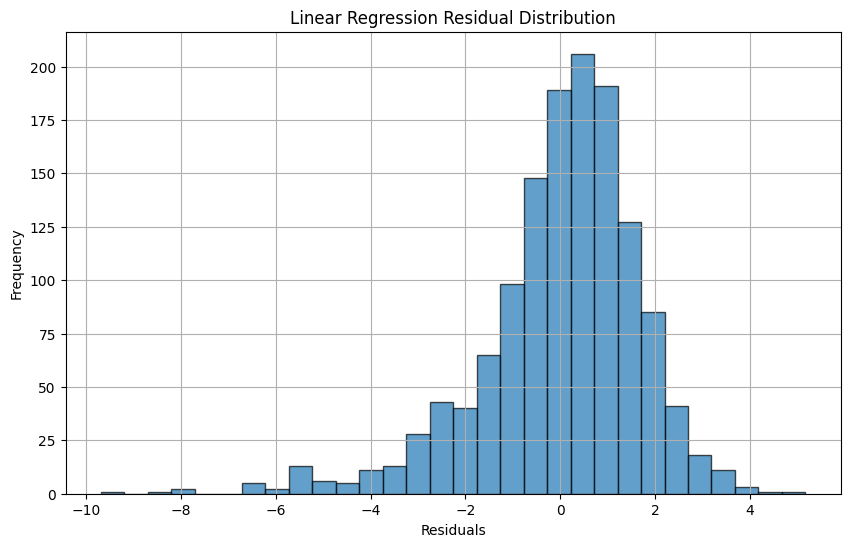

Polynomial regression RMSE:  [1.5 1.8 1.7 1.7 1.7]
Avg. RMSE:  1.692937754806458 



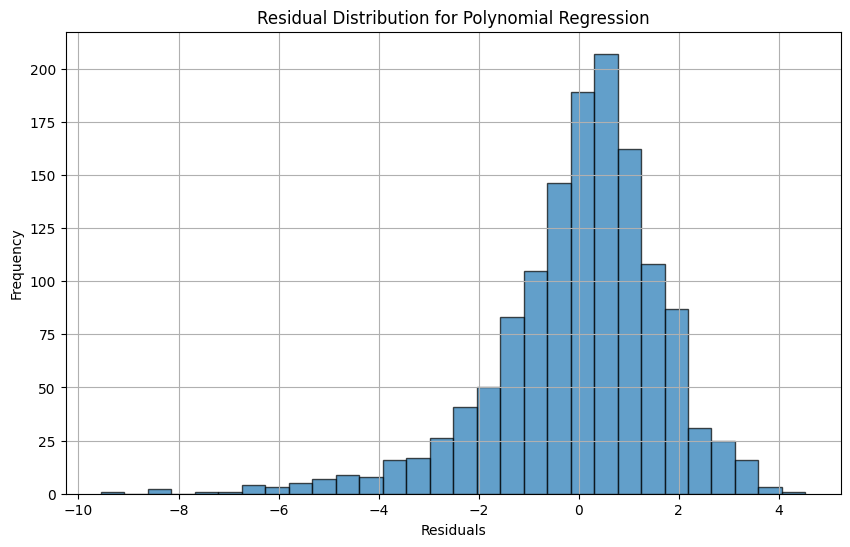

DecisionTreeRegressor rmse:  [2.31937134 2.33333773 2.54809096 2.34012804 2.39169861]
Avg. rmse:  2.3865253339680765 



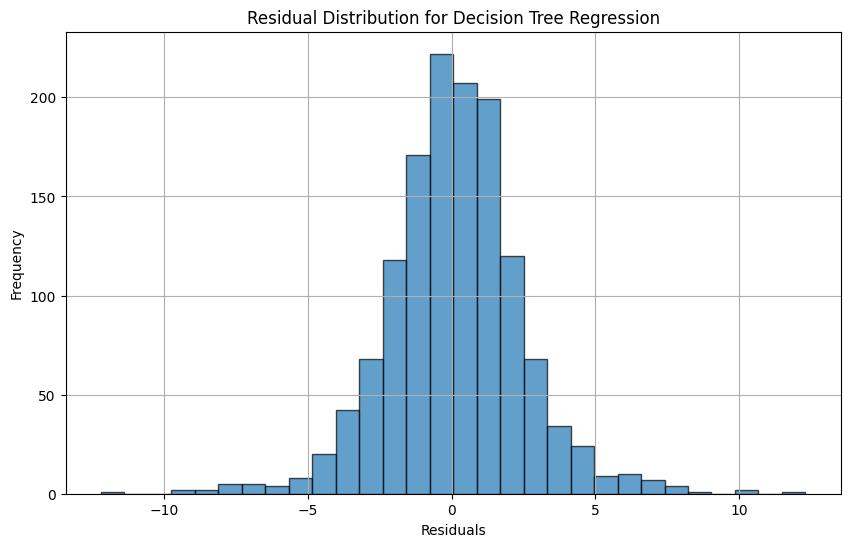

RandomForestRegressor rmse:  [1.68078175 2.0421138  1.81578808 1.89285196 1.8986939 ]
Avg. rmse:  1.8660458997274643 



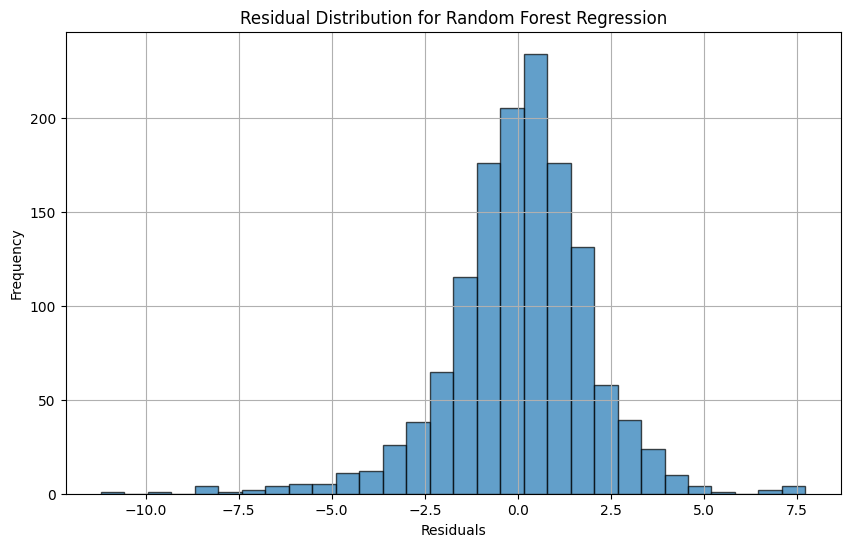

LightGBM rmse:  [1.64632353 1.87266677 1.76398591 1.81733004 1.77799504]
Avg. rmse:  1.7756602572875178 



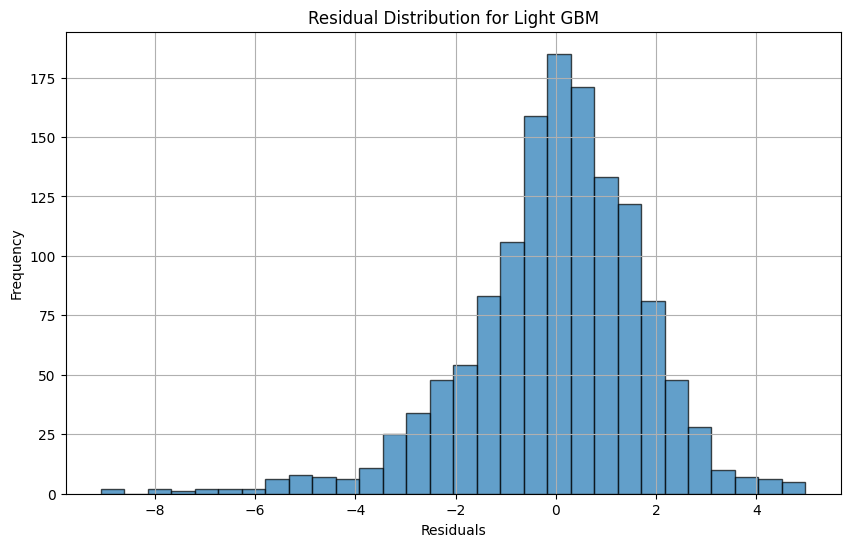

XGBoost rmse:  [1.65949169 2.04272625 1.87663818 1.84685084 1.84880585]
Avg. rmse:  1.8549025611541374 



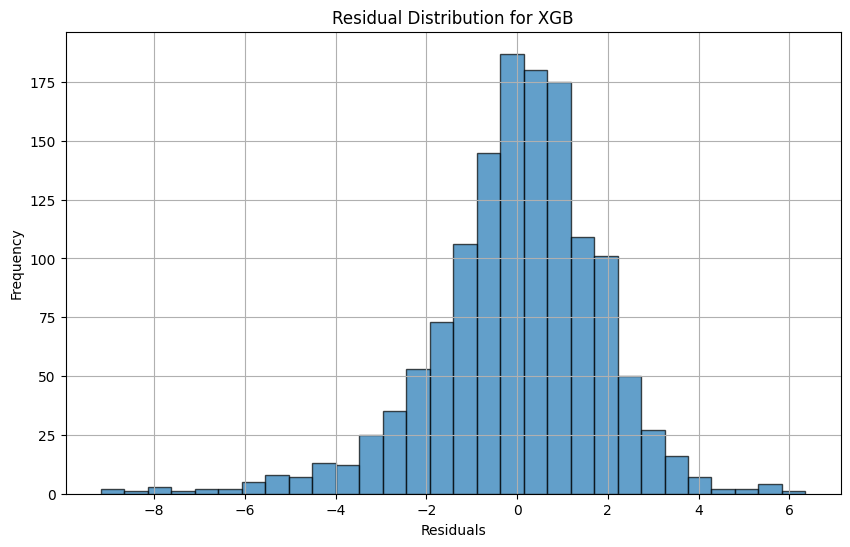

KNeighbor rmse:  [1.63851026 1.90168308 1.80155775 1.79882701 1.77533847]
Avg. rmse:  1.7831833116230849 



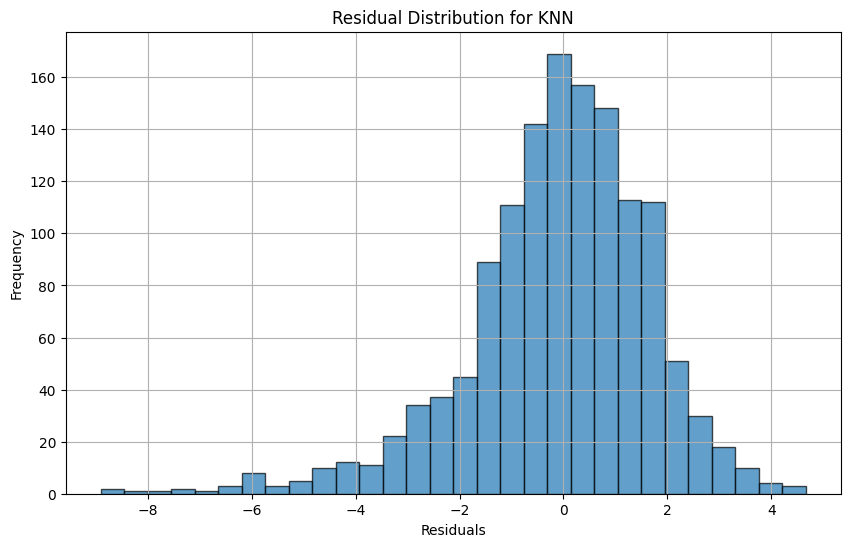

SVR rmse:  [1.48333477 1.91388418 1.72234191 1.82091605 1.83877581]
Avg. rmse:  1.7558505444990793 



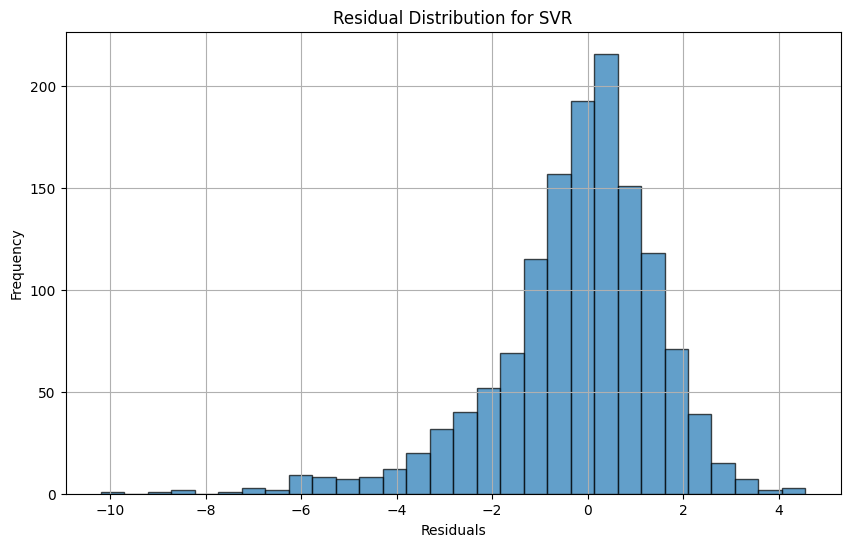

21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in

Prophet RMSE:  [5.71139846 5.75694527 6.05342146 5.91035311 6.34143985]
Avg. RMSE:  5.954711627801486 



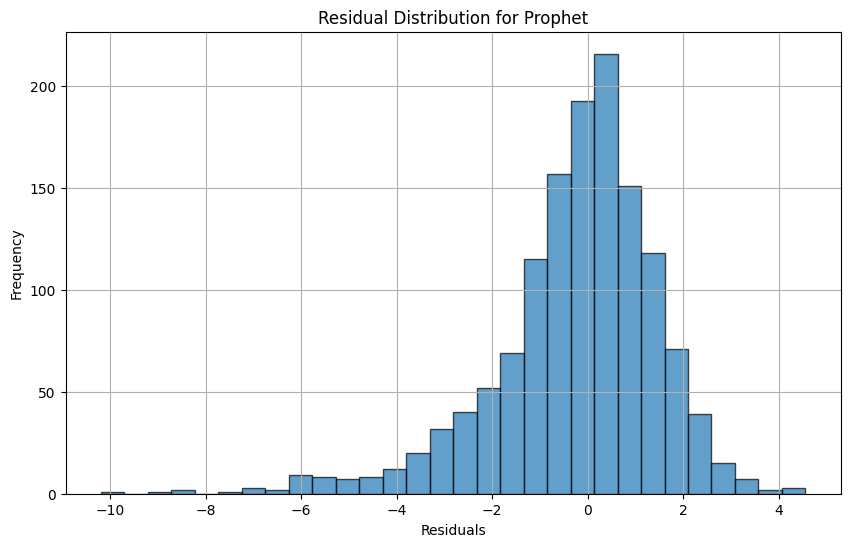

In [26]:
# cv1 = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42); 
# cv2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42); 
# cv3 = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42); 

# Custom transformer to add a sequential date column
class DateAdder(BaseEstimator, TransformerMixin):
    def __init__(self, start_date='2020-01-01'):
        self.start_date = pd.to_datetime(start_date)
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Create a 'ds' column with sequential dates starting from 'start_date'
        X['ds'] = pd.date_range(start=self.start_date, periods=len(X), freq='D')
        return X

# Wrapper for Prophet to integrate with scikit-learn pipeline
class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, yearly_seasonality=True):
        self.yearly_seasonality = yearly_seasonality
        self.model = None

    def fit(self, X, y=None):
        df = X.copy()
        df['y'] = y  # Prophet requires the target column to be named 'y'
        self.model = Prophet(yearly_seasonality=self.yearly_seasonality)
        
        # Add additional regressors
        for col in X.columns:
            if col != 'ds':  # Assuming 'ds' is the date column created in the pipeline
                self.model.add_regressor(col)
                
        self.model.fit(df[['ds', 'y'] + [col for col in X.columns if col != 'ds']])
        return self

    def predict(self, X, y=None):
        forecast = self.model.predict(X[['ds'] + [col for col in X.columns if col != 'ds']])
        return forecast['yhat']

# Function to calculate R² score and RMSE
def r2score_and_rmse(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    return r2, rmse

# Function to store model
def store_model(model, model_name="Prophet_model.pkl"):
    joblib.dump(model, model_name)
    print(f"Model successfully saved as {model_name}")


print('\n____________ K-fold cross validation ____________')
cv = KFold(n_splits=5,shuffle=True,random_state=37) # cv data generator

run_new_evaluation = 1
if run_new_evaluation:
    #Evaluate LinearRegression
    model_name = "LinearRegression"
    model = LinearRegression()
    nmse_scores = cross_val_score(model, X_train, y_train,cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("LinearRegression rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Predict using cross-validation
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred
    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Linear Regression Residual Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    

    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('lin_reg', LinearRegression())
    ])

    # Perform cross-validation and evaluate
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)

    # Save the RMSE scores
    model_name = "PolynomialRegression"
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')

    print("Polynomial regression RMSE: ", rmse_scores.round(decimals=1))
    print("Avg. RMSE: ", np.mean(rmse_scores), '\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Polynomial Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    model_name = "DecisionTreeRegressor" 
    model = DecisionTreeRegressor()
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("DecisionTreeRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')


    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Decision Tree Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Evaluate RandomForestRegressor
    model_name = "RandomForestRegressor" 
    model = RandomForestRegressor(n_estimators = 5)
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
    print("RandomForestRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Random Forest Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate LGBM
    model_name = "LightGBM"
    model = lgb.LGBMRegressor(verbose = -1)
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("LightGBM rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Light GBM')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate XGB BoostRegressor
    model_name = "XGBoostRegressor"
    model = XGBRegressor()
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("XGBoost rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for XGB')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate K nearest Neighbor
    model_name = "KNeighbor"
    model = KNeighborsRegressor(n_neighbors=5)
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("KNeighbor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for KNN')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate SVR M
    model_name = "SVR_model"
    model = SVR(kernel='rbf')
    nmse_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    print("SVR rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for SVR')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Evaluate Prophet 
    model_name = "Prophet"
    rmse_scores = []
    r2_scores = []
    
    for train_index, test_index in cv.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Initialize and train the Prophet model using the pipeline
        pipeline = Pipeline([
            ('date_adder', DateAdder(start_date='2020-01-01')),  # Add a 'ds' date column
            ('prophet', ProphetWrapper(yearly_seasonality=True))  # Prophet model wrapper
        ])
        
        pipeline.fit(X_train_fold, y_train_fold)
        r2, rmse = r2score_and_rmse(pipeline, X_test_fold, y_test_fold)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    rmse_scores = np.array(rmse_scores)
    r2_scores = np.array(r2_scores)
    joblib.dump((rmse_scores, r2_scores), 'saved_objects/' + model_name + '_scores.pkl')
    print("Prophet RMSE: ", rmse_scores)
    print("Avg. RMSE: ", np.mean(rmse_scores), '\n')

    # Step 2: Perform cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    # Step 3: Calculate residuals
    residuals = y_train - y_train_pred

    # Step 4: Plot the residual distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Residual Distribution for Prophet')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    #Load LinearRegression
    model_name = "LinearRegression" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("\nLinearRegression rmse: ", rmse_scores.round(decimals=1))
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Load PolynomialRegression:
    model_name = "PolinomialRegression" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("Polinomial regression rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Load DecisionTreeRegressor
    model_name = "DecisionTreeRegressor" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("DecisionTreeRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')
    
    #Load RandomForestRegressor
    model_name = "RandomForestRegressor" 
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("RandomForestRegressor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load LightGBM
    model_name = "LightGBM"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("LightGBM rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load XGB
    model_name = "XGBoostRegressor"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("XGBoost rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load KNeighbor"
    model_name = "KNeighbor"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("KNeighbor rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load "SVR_model"
    model_name = "SVR_model"
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    print("SVR rmse: ", rmse_scores)
    print("Avg. rmse: ", mean(rmse_scores),'\n')

    #Load Prophet
    model_name = "Prophet"
    rmse_scores, r2_scores = joblib.load('saved_objects/' + model_name + '_scores.pkl')
    print("Prophet RMSE: ", rmse_scores)
    print("Avg. RMSE: ", np.mean(rmse_scores), '\n')

### 5.11 So which one to choose?
Our team based on the average RMSE and the residual distribution plot to determine the best model.
Below is our observations:

<body>
    <div class="model">
        <h4>Linear Regression</h4>
        <p>Avg RMSE: 1.702138887520721</p>
        <p>Residuals are somewhat normally distributed, but there's a noticeable spread and some outliers. This indicates that linear regression may not capture all the complexities of the data. Hence this model is not a good option</p>
    </div>
    <div class="model">
        <h4>Polynomial Regression</h4>
        <p>Avg. RMSE:  1.692937754806458</p>
        <p>The residuals appear to be more centered around zero and show a tighter distribution. This suggests that polynomial regression may better fit the data, considering non-linear relationships.</p>
    </div>
    <div class="model">
        <h4>Decision Tree Regression</h4>
        <p>Avg. RMSE: 2.3865253339680765</p>
        <p>The residuals are also centered around zero and show a good distribution. Decision trees can capture non-linear patterns well, making this a strong contender.</p>
    </div>
    <div class="model">
        <h4>Random Forest Regression</h4>
        <p>Avg. RMSE:  1.8660458997274643 </p>
        <p>Similar to decision trees, the residuals are well-centered and exhibit a good distribution. Random forests usually provide more stability and better generalization than single decision trees.</p>
    </div>
    <div class="model">
        <h4>Light GBM</h4>
        <p>Avg. RMSE: 1.7756602572875178</p>
        <p>The residuals show a very similar pattern to those of the random forest, indicating a good fit. Light GBM is often efficient and effective for large datasets.</p>
    </div>
    <div class="model">
        <h4>XGBoost (XGB)</h4>
        <p>Avg. RMSE: 1.7831833116230849</p>
        <p>The residual distribution is also symmetric and centered around zero, showing a good fit. It appears to perform similarly to Random Forest and Light GBM.</p>
    </div>
    <div class="model">
        <h4>K-Nearest Neighbors (KNN)</h4>
        <p>Avg. RMSE: 1.8549025611541374</p>
        <p>The residuals show a good distribution centered around zero, but there may be slightly more spread compared to the previous models. It is still a strong option.</p>
    </div>
    <div class="model">
        <h4>Support Vector Regression (SVR)</h4>
        <p>Avg. RMSE: 1.7558505444990793</p>
        <p>The residuals are centered around zero, but there are some noticeable tails and a slight skewness. This suggests that while SVR performs reasonably well, it may not be as effective as the other models.</p>
    </div>
    <div class="model">
        <h4>Prophet Model Evaluation</h4>
        <p>Avg. RMSE: 5.954711627801486</p>
        <p>The residuals appear to be somewhat symmetric and centered around zero, indicating that the model captures the underlying data trends reasonably well. However, the plot seems to have a skew, indicating that it might not be as robust as XGB, LightGBM, and Random Forest</p>
    </div>
</body>

### By evaluation on the residual distribution plot and the average rmse score, our team decided to fine tune the xgboost, lightgbm, and Random Forest model

# Step 6: Fine tuning

In [28]:
print('\n____________ Fine-tune models ____________')

# Function to print results of grid search
def print_search_result(grid_search, model_name = ""): 
    print("\n====== Fine-tune " + model_name +" ======")
    print('Best hyperparameter combination: ',grid_search.best_params_)
    print('Best rmse: ', np.sqrt(-grid_search.best_score_))  
    print('Performance of hyperparameter combinations:')
    cv_results = grid_search.cv_results_
    for (mean_score, params) in zip(cv_results["mean_test_score"], cv_results["params"]):
        print('rmse =', np.sqrt(-mean_score), params) 

method = 3
if method == 1: #XGBoost
    from sklearn.model_selection import GridSearchCV
    cv = KFold(n_splits=5,shuffle=True,random_state=37)

    run_new_search = 0
    if run_new_search:
        model = XGBRegressor()
        
        # Define parameter grid for search
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'gamma': [0, 0.1, 0.5, 1],
            'alpha': [0, 0.1, 0.5, 1],
            'lambda': [0, 0.1, 0.5, 1]
        }
        
        # Set up and run grid search
        xgb_model = XGBRegressor(random_state=42)
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        # Save grid search results
        joblib.dump(grid_search, 'saved_objects/XGBRegressor_gridsearch.pkl')
        
        # Print search results
        print_search_result(grid_search, model_name = "XGBRegressor")
        print("Range of y_train:", y_train.min(), "to", y_train.max())
        
        from sklearn.metrics import mean_squared_error
        
        # Get best model from grid search
        best_model = grid_search.best_estimator_

        # Make predictions on training data
        y_train_pred = best_model.predict(X_train)

        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_train, y_train_pred, color='purple', alpha=0.5)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Line of perfect prediction
        plt.title('Actual vs. Predicted - Training Set')
        plt.xlabel('Actual y_train values')
        plt.ylabel('Predicted y_train values')
        plt.show()

        # Calculate and plot residuals
        residuals = y_train - y_train_pred

        import seaborn as sns
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True, color='green')
        plt.title('Distribution of Residuals - Training Set')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()
    else:
        # Load previously saved grid search results
        grid_search = joblib.load('saved_objects/XGBRegressor_gridsearch.pkl')
        print_search_result(grid_search, model_name= "XGBRegressor")
        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_train, y_train_pred, color='purple', alpha=0.5)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Line of perfect prediction
        plt.title('Actual vs. Predicted - Training Set')
        plt.xlabel('Actual y_train values')
        plt.ylabel('Predicted y_train values')
        plt.show()

        # Calculate and plot residuals
        residuals = y_train - y_train_pred

        import seaborn as sns
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True, color='green')
        plt.title('Distribution of Residuals - Training Set')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()
elif method == 2:
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import Pipeline
    import seaborn as sns
    from scipy import stats

    cv = KFold(n_splits=5, shuffle=True, random_state=37)
    
    run_new_search = 0
    if run_new_search:
        # Create a pipeline that includes polynomial features and linear regression
        model = Pipeline([
            ('poly', PolynomialFeatures()),
            ('linear', LinearRegression())
        ])
        
        # Define parameter grid for search
        param_grid = {
            'poly__degree': [1, 2, 3],  # Degree of polynomial features
            'linear__fit_intercept': [True, False],  # Whether to calculate the intercept
        }
        
        # Set up and run grid search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                   scoring='neg_mean_squared_error', cv=cv, 
                                   n_jobs=-1, verbose=1)
        
        # Fit the grid search
        grid_search.fit(X_train, y_train)
        
        # Save grid search results
        joblib.dump(grid_search, 'saved_objects/LinearRegression_gridsearch.pkl')
        
        # Print search results
        print_search_result(grid_search, model_name="LinearRegression")
        
        # Get best model from grid search
        best_model = grid_search.best_estimator_

        # Make predictions on training data
        y_train_pred = best_model.predict(X_train)

        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_train, y_train_pred, color='purple', alpha=0.5)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Line of perfect prediction
        plt.title('Actual vs. Predicted - Training Set')
        plt.xlabel('Actual y_train values')
        plt.ylabel('Predicted y_train values')
        plt.show()

        # Calculate and plot residuals
        residuals = y_train - y_train_pred

        import seaborn as sns
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True, color='green')
        plt.title('Distribution of Residuals - Training Set')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()
    else:
        # Load previously saved grid search results
        grid_search = joblib.load('saved_objects/LinearRegression_gridsearch.pkl')
        print_search_result(grid_search, model_name= "LinearRegression")
        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_train, y_train_pred, color='purple', alpha=0.5)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Line of perfect prediction
        plt.title('Actual vs. Predicted - Training Set')
        plt.xlabel('Actual y_train values')
        plt.ylabel('Predicted y_train values')
        plt.show()

        # Calculate and plot residuals
        residuals = y_train - y_train_pred

        import seaborn as sns
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True, color='green')
        plt.title('Distribution of Residuals - Training Set')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()
elif method == 3:
    run_new_search = 1
    if run_new_search:
        from lightgbm import LGBMRegressor
        from sklearn.model_selection import GridSearchCV
        import joblib
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import mean_squared_error

        model = LGBMRegressor(random_state=42)

        # Define parameter grid for search
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, -1],
            'learning_rate': [0.01, 0.1, 0.3],
            'num_leaves': [31, 50, 100],
            'min_child_samples': [20, 30, 50],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'reg_alpha': [0, 0.1, 0.5, 1],
            'reg_lambda': [0, 0.1, 0.5, 1]
        }

        # Set up and run grid search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                scoring='neg_mean_squared_error', cv=cv, 
                                n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        # Save grid search results
        joblib.dump(grid_search, 'saved_objects/LGBMRegressor_gridsearch.pkl')

        # Print search results
        print_search_result(grid_search, model_name="LGBMRegressor")
        print("Range of y_train:", y_train.min(), "to", y_train.max())

        # Get best model from grid search
        best_model = grid_search.best_estimator_

        # Make predictions on training data
        y_train_pred = best_model.predict(X_train)

        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_train, y_train_pred, color='purple', alpha=0.5)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Line of perfect prediction
        plt.title('Actual vs. Predicted - Training Set')
        plt.xlabel('Actual y_train values')
        plt.ylabel('Predicted y_train values')
        plt.show()

        # Calculate and plot residuals
        residuals = y_train - y_train_pred

        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True, color='green')
        plt.title('Distribution of Residuals - Training Set')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()
    else:
        # Load previously saved grid search results
        grid_search = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl')
        print_search_result(grid_search, model_name= "LGBMRegressor")
        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_train, y_train_pred, color='purple', alpha=0.5)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)  # Line of perfect prediction
        plt.title('Actual vs. Predicted - Training Set')
        plt.xlabel('Actual y_train values')
        plt.ylabel('Predicted y_train values')
        plt.show()

        # Calculate and plot residuals
        residuals = y_train - y_train_pred

        import seaborn as sns
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True, color='green')
        plt.title('Distribution of Residuals - Training Set')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()


____________ Fine-tune models ____________
Fitting 5 folds for each of 20736 candidates, totalling 103680 fits


## STEP 7: ANALYZE AND TEST YOUR SOLUTION

7.1. Pick the best model - the SOLUTION:
As we have explained above, we have choose and fine-tuned XGB Model

In [44]:
search = joblib.load('saved_objects/XGBRegressor_gridsearch.pkl')
best_model = search.best_estimator_
print('\n____________ ANALYZE AND TEST SOLUTION ____________')
print('SOLUTION: ' , best_model)
store_model(best_model, model_name="SOLUTION")   


____________ ANALYZE AND TEST SOLUTION ____________
SOLUTION:  XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.5, learning_rate=0.1,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None, ...)
Model successfully saved as SOLUTION


7.2 Analyze the SOLUTION to get more insights about the data (NOTE: For XGBoost Model)


Features and importance scores:
feelslike: 0.5024
feelslikemax: 0.2737
tempmin: 0.1519
tempmax: 0.0167
feelslikemin: 0.0163
sealevelpressure: 0.0152
dew: 0.0142
humidity: 0.0096


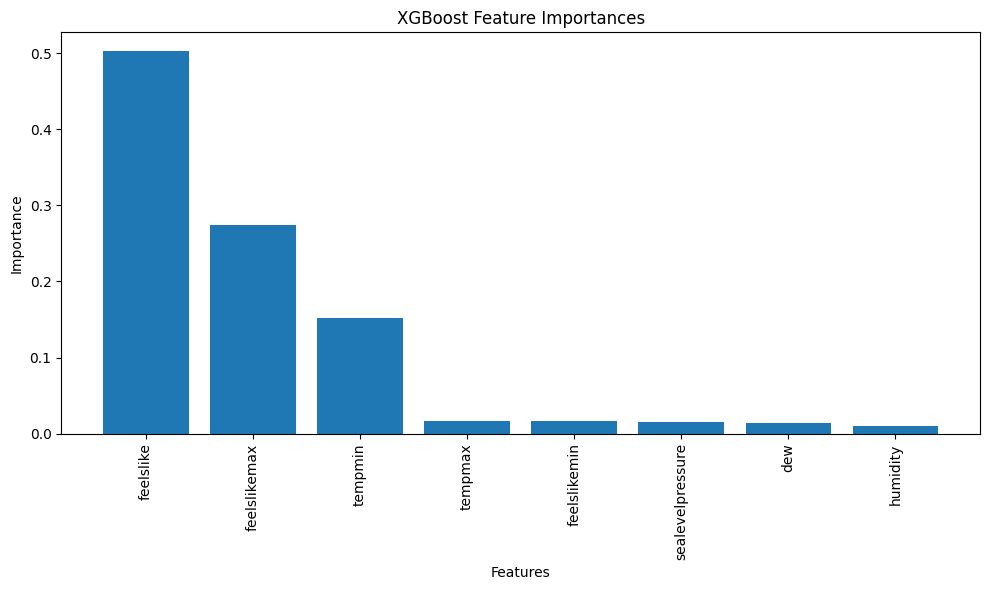

In [45]:
if type(best_model).__name__ == "XGBRegressor":
    # Get feature importances
    feature_importances = best_model.feature_importances_
    
    # Get feature names (assuming X_train.columns contains your feature names)
    feature_names = X_train.columns.tolist()
    
    # Create a list of tuples with feature names and their importance scores
    feature_importance_pairs = list(zip(feature_names, feature_importances))
    
    # Sort the pairs by importance score in descending order
    sorted_importances = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
    
    print('\nFeatures and importance scores:')
    for name, importance in sorted_importances:
        print(f"{name}: {importance:.4f}")

    # Optionally, you can create a bar plot of feature importances
    plt.figure(figsize=(10, 6))
    plt.bar([x[0] for x in sorted_importances], [x[1] for x in sorted_importances])
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('XGBoost Feature Importances')
    plt.tight_layout()
    plt.show()

7.3 Run on test data

In [46]:
#%% 7.3 Run on test data
try:
    num_pipeline = joblib.load(r'models/num_pipeline.pkl')
except FileNotFoundError:
    print("Error: num_pipeline.pkl file not found. Make sure you have saved the pipeline.")
    # Nếu không tìm thấy file, bạn có thể cần phải tạo và lưu pipeline trước

processed_test_set = num_pipeline.transform(test_set)
# 7.3.1 Compute R2 score and root mean squared error
r2score, rmse = r2score_and_rmse(best_model, processed_test_set, y_test)
print('\nPerformance on test data:')
print('R2 score (on test data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# 7.3.2 Predict labels for some test instances
print("\nTest data: \n", X_test.iloc[0:9])
print("\nPredictions: ", best_model.predict(processed_test_set[0:9]).round(decimals=1))
print("Labels:      ", list(y_test[0:9]),'\n')

print("\nProcessed: \n", processed_test_set)


Performance on test data:
R2 score (on test data, best=1): 0.9089016418192863
Root Mean Square Error:  1.6080719950235012

Test data: 
    feelslike   tempmax  feelslikemax   tempmin  feelslikemin       dew  \
0   1.531874  1.296318      1.403462  0.637695      0.376529  1.048752   
1   1.275963  0.775198      1.215943  1.041398      1.343747  1.065685   
2   0.213933 -0.065317      0.038739  0.637695      0.376529  0.794765   
3   0.329093  0.943301      0.872158  0.435844      0.215326  0.540777   
4   1.250372  1.111404      1.143019  1.041398      1.343747  0.913292   
5  -0.988848 -1.174797     -1.138464 -0.775264     -0.751891 -0.559836   
6  -0.758528 -0.737729     -0.867603 -0.573413     -0.590688 -0.255051   
7   0.789732  0.775198      0.955500  0.839546      0.537732  0.947157   
8  -1.001643 -0.670488     -0.825932 -1.421188     -1.267741 -2.083761   

   sealevelpressure  humidity  
0         -1.182361  0.053713  
1         -1.351989  0.567749  
2         -0.574529  1.109

/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
